In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import DataSplitter

In [2]:
df60 = DataSplitter.getTrainData(60)

target_column = "diff"
drop_cols = ["date", "hour", "year", "quarter", "Q1", "month", "monthNumber", "weekNumber", "weekDay", "dateNumber", "mon", "workdayPlan", "line", "passengersBoarding", "datetime", "eventName"]

train60, val60 = DataSplitter.performTrainValSplit(df60)
train60_1A = train60[train60["line"] == "1A"]
val60_1A = val60[val60["line"] == "1A"]

X_train = train60_1A.drop(columns=([target_column] + drop_cols), axis=1).reset_index(drop=True)
X_val = val60_1A.drop(columns=([target_column] + drop_cols), axis=1).reset_index(drop=True)
y_train = train60_1A[target_column].reset_index(drop=True)
y_val = val60_1A[target_column].reset_index(drop=True)

In [3]:
batchSize = 16

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled).squeeze(-1)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val_scaled).squeeze(-1)

trainDataset = TensorDataset(X_train_tensor, y_train_tensor)
trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=False)

valDataset = TensorDataset(X_val_tensor, y_val_tensor)
valLoader = DataLoader(valDataset, batch_size=batchSize, shuffle=False)

In [4]:
def evaluation(model, loader, loss_fn, device):
    model.eval()
    total_loss = []
    with torch.no_grad():
        for batch_idx, (Xbatch, ybatch) in enumerate(loader):
            Xbatch = Xbatch.to(device)
            ybatch = ybatch.to(device)
            
            predictions = model(Xbatch)

            loss = loss_fn(predictions, ybatch)
            total_loss.append(loss.item())
    return np.mean(total_loss)

In [5]:
if torch.cuda.is_available():
    print("cuda")
    device = torch.device("cuda")
else:
    print("cpu")
    device = torch.device("cpu")

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, num_layers=1, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        #self.tanh = nn.Tanh()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

cuda


In [6]:
model = LSTM()#.to(device)
totalEpochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction="mean")

train_loss_list = []
val_loss_list = []
nEpochs = range(1, totalEpochs + 1)
for epoch in nEpochs:
    model.train()

    optimizer.zero_grad()

    predictions = model(X_train_tensor.unsqueeze(-1)).squeeze()

    loss = criterion(predictions, y_train_tensor)
    loss.backward()

    optimizer.step()

    #val_loss = evaluation(model, valLoader, criterion, device)

    train_loss_list.append(loss.item())
    #val_loss_list.append(val_loss)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Train Loss: {loss.item()}")#, Val Loss: {val_loss}")

train_loss_list = np.array(train_loss_list)
#val_loss_list = np.array(val_loss_list)
#np.save(train_loss_list, "train_loss.npy")
#np.save(val_loss_list, "val_loss.npy")

Epoch: 10, Train Loss: 0.9705474376678467


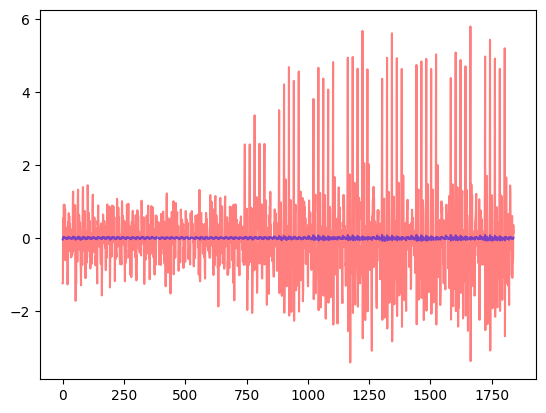

In [17]:
import matplotlib.pyplot as plt

plt.plot(y_val_tensor, color="red", alpha=0.5)
plt.plot(model(X_val_tensor.unsqueeze(-1)).detach().numpy(), color="blue", alpha=0.5)